<a href="https://colab.research.google.com/github/pojeesahil/DS/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Authenticating with Google Earth Engine...
Earth Engine initialized successfully!
Analyzing area around: 19.93, 73.53...
Fetching satellite data & calculating erosion risk...
Applying Smart Mask (Removing Cities, Water, Snow)...
Data Downloaded! Grid Size: 185x195

Starting Training (100 Epochs)...
Epoch 0 | Loss: 1.2720
Epoch 20 | Loss: 0.4793
Epoch 40 | Loss: 0.3750
Epoch 60 | Loss: 0.2962
Epoch 80 | Loss: 0.2278
Epoch 100 | Loss: 0.1683
Model saved to 'erosion_model_19.93_73.53.pth'
Generating Map...
Done! Check 'erosion_map_19.93_73.53.png' for your Red/Yellow map.


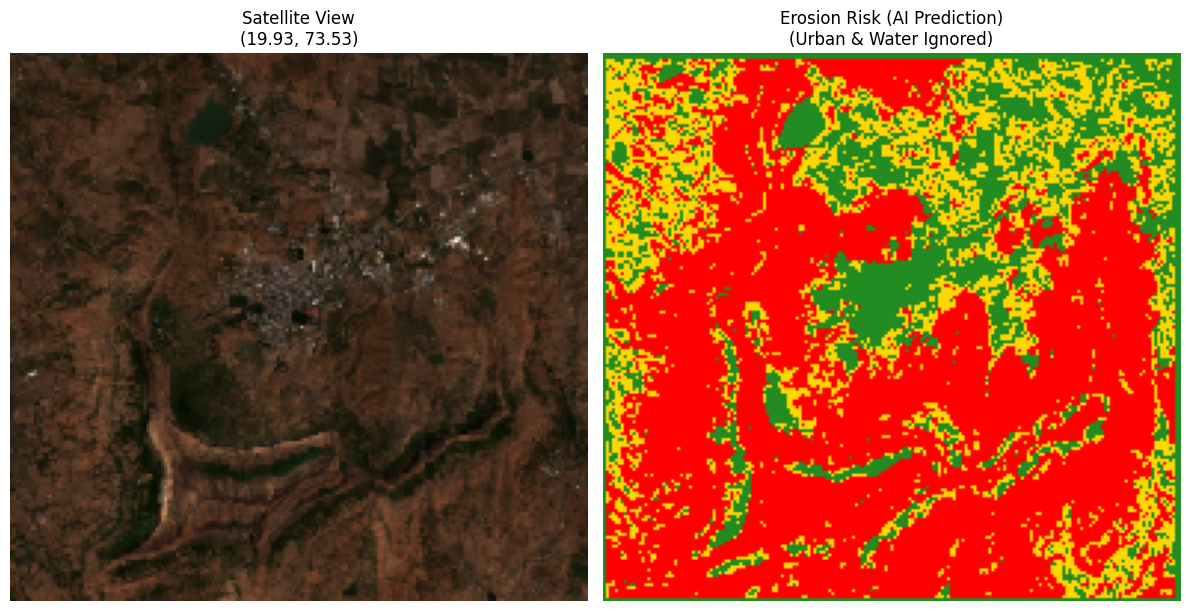

In [3]:
import ee
import geemap
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import os

# ==========================================
# 📍 USER SETTINGS (CHANGE THIS)
# ==========================================
# Example: Hills near Nashik/Trimbakeshwar
LAT = 19.93
LON = 73.53

# Radius of area to analyze (in meters)
# 2750m radius = ~5.5km x 5.5km box
SIZE_METERS = 2750
# ==========================================
MY_PROJECT = 'gen-lang-client-0426799622'
# --- PART 1: GOOGLE EARTH ENGINE SETUP ---
print("Authenticating with Google Earth Engine...")

# This is the professional standard for shared notebooks
def initialize_gee():
    try:
        # Try to initialize with the project ID
        ee.Initialize(project=MY_PROJECT)
        print("Earth Engine initialized successfully!")
    except Exception:
        # If it's their first time, they need to log in
        print("Authenticating... Please follow the popup instructions.")
        ee.Authenticate()
        ee.Initialize(project=MY_PROJECT)
        print("Successfully authenticated and initialized!")

initialize_gee()
# Create Dynamic ROI (Box around your point)
point = ee.Geometry.Point([LON, LAT])
roi = point.buffer(SIZE_METERS).bounds()

print(f"Analyzing area around: {LAT}, {LON}...")

# --- PART 2: CALCULATE RUSLE FACTORS (The Teacher) ---
print("Fetching satellite data & calculating erosion risk...")

# 1. R Factor (Rainfall - CHIRPS)
# We sum daily rainfall for the full year
rain = ee.ImageCollection("UCSB-CHG/CHIRPS/DAILY") \
    .filterDate('2023-01-01', '2023-12-31') \
    .sum().clip(roi)
R = rain.pow(1.61).multiply(0.0483).rename('R')

# 2. K Factor (Soil Erodibility - OpenLandMap)
soil = ee.Image("OpenLandMap/SOL/SOL_TEXTURE-CLASS_USDA-TT_M/v02").clip(roi)
# Map USDA classes to K values (Sand=0.05 ... Clay=0.2 ... Silt=0.3)
K = soil.remap([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
               [0.05, 0.15, 0.2, 0.25, 0.3, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6],
               0.3).rename('K')

# 3. LS Factor (Slope - SRTM)
dem = ee.Image("USGS/SRTMGL1_003").clip(roi)
slope_deg = ee.Terrain.slope(dem)
# Simplified LS proxy equation
LS = slope_deg.divide(100).pow(1.3).multiply(2).rename('LS')

# 4. C Factor (Vegetation - Sentinel-2)
def mask_s2_clouds(image):
    qa = image.select('QA60')
    mask = qa.bitwiseAnd(1<<10).eq(0).And(qa.bitwiseAnd(1<<11).eq(0))
    return image.updateMask(mask).divide(10000)

s2 = (ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
      .filterBounds(roi)
      .filterDate('2023-01-01', '2023-06-30') # Dry season preferred for bare soil detection
      .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20))
      .map(mask_s2_clouds)
      .median()
      .clip(roi))

ndvi = s2.normalizedDifference(['B8', 'B4'])
C = ndvi.expression("exp(-2 * (ndvi / (1 - ndvi)))", {'ndvi': ndvi}).rename('C')
C = C.where(C.gt(1), 1).where(C.lt(0), 0)

# --- 🆕 SMART MASKING (Remove False Positives) ---
print("Applying Smart Mask (Removing Cities, Water, Snow)...")
# ESA WorldCover:
# 50 = Built-up (Cities/Roads)
# 80 = Permanent Water Bodies (Rivers/Lakes)
# 100 = Moss/Lichen (often high altitude rock)
# 60 = Bare / sparse vegetation (KEEP - This is where erosion happens!)

landcover = ee.ImageCollection("ESA/WorldCover/v100").first().clip(roi)

# Create a mask: Keep pixels that are NOT Urban AND NOT Water
valid_mask = landcover.neq(50).And(landcover.neq(80)).And(landcover.neq(100))

# Apply mask to Soil Loss Calculation
# If invalid, K becomes 0, so Soil Loss becomes 0 (Safe/Black)
K_corrected = K.updateMask(valid_mask).unmask(0)

# --- CALCULATE RISK & LABELS ---
# A = R * K * LS * C
soil_loss = R.multiply(K_corrected).multiply(LS).multiply(C)

# Traffic Light Classes:
# 0 = Safe (< 5 tons) -> GREEN
# 1 = Moderate (5 - 20 tons) -> YELLOW
# 2 = High (> 20 tons) -> RED
class_map = ee.Image(0) \
    .where(soil_loss.gte(5).And(soil_loss.lt(20)), 1) \
    .where(soil_loss.gte(20), 2) \
    .rename('erosion_class')

# --- PREPARE DOWNLOAD ---
# Input features for AI: [Red, Green, Blue, NIR, Slope]
inputs = s2.select(['B4', 'B3', 'B2', 'B8']).addBands(slope_deg.divide(90))
feature_stack = inputs.addBands(class_map)

print("Downloading data to local machine...")
# scale=30 matches Sentinel resolution
pixel_data = geemap.ee_to_numpy(feature_stack, region=roi, scale=30)
pixel_data = np.nan_to_num(pixel_data, nan=0.0)

if pixel_data.shape[0] == 0 or pixel_data.shape[1] == 0:
    raise ValueError("Error: Downloaded data is empty. Check your Lat/Lon!")

print(f"Data Downloaded! Grid Size: {pixel_data.shape[0]}x{pixel_data.shape[1]}")

# --- PART 3: TRAIN AI (PyTorch) ---
data_tensor = torch.from_numpy(pixel_data).float().permute(2, 0, 1)

# X = Inputs (5 channels), Y = Labels (1 channel)
X = data_tensor[:5, :, :].unsqueeze(0)
Y = data_tensor[5, :, :].long().unsqueeze(0)

class MultiClassUNet(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(MultiClassUNet, self).__init__()
        self.enc1 = self.conv_block(in_channels, 16)
        self.enc2 = self.conv_block(16, 32)
        self.pool = nn.MaxPool2d(2)
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.dec1 = self.conv_block(32 + 16, 16)
        self.final = nn.Conv2d(16, num_classes, kernel_size=1)

    def conv_block(self, in_c, out_c):
        return nn.Sequential(
            nn.Conv2d(in_c, out_c, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(out_c),
            nn.Conv2d(out_c, out_c, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(out_c)
        )

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        d1 = self.up(e2)
        if d1.size() != e1.size():
            d1 = torch.nn.functional.interpolate(d1, size=e1.shape[2:])
        d1 = torch.cat([d1, e1], dim=1)
        out = self.dec1(d1)
        return self.final(out)

model = MultiClassUNet(in_channels=5, num_classes=3)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

print("\nStarting Training (100 Epochs)...")
for epoch in range(101):
    optimizer.zero_grad()
    outputs = model(X)
    loss = criterion(outputs, Y)
    loss.backward()
    optimizer.step()

    if epoch % 20 == 0:
        print(f"Epoch {epoch} | Loss: {loss.item():.4f}")

# Save Model
torch.save(model.state_dict(), f"erosion_model_{LAT}_{LON}.pth")
print(f"Model saved to 'erosion_model_{LAT}_{LON}.pth'")

# --- PART 4: VISUALIZE RESULTS ---
print("Generating Map...")
with torch.no_grad():
    logits = model(X)
    prediction = torch.argmax(logits, dim=1).squeeze().numpy()

# Custom Map: Green (Safe), Yellow (Moderate), Red (High)
cmap = ListedColormap(['#228B22', '#FFD700', '#FF0000'])

plt.figure(figsize=(12, 6))

# 1. Satellite View
rgb = pixel_data[:, :, 0:3]
rgb = (rgb - np.min(rgb)) / (np.max(rgb) - np.min(rgb))
plt.subplot(1, 2, 1)
plt.imshow(rgb)
plt.title(f"Satellite View\n({LAT}, {LON})")
plt.axis('off')

# 2. Risk Map
plt.subplot(1, 2, 2)
# We use vmin=0, vmax=2 to ensure the colors map correctly to the 0,1,2 classes
plt.imshow(prediction, cmap=cmap, vmin=0, vmax=2)
plt.title("Erosion Risk (AI Prediction)\n(Urban & Water Ignored)")
plt.axis('off')

filename = f"erosion_map_{LAT}_{LON}.png"
plt.tight_layout()
plt.savefig(filename)
print(f"Done! Check '{filename}' for your Red/Yellow map.")